# CKD Symptomatic Risk Analysis for Sri Lanka

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load the data set
#### 1. Data Loading and Initial Exploration

In [3]:
df = pd.read_excel('risk_of_ckd.xlsx')

### Displaying the First Few Rows and Data Information of the DataFrame

In [4]:
df.head()

,id,age,gender,diabetic,family_history,obesity,smoking,alcohol,prolong_use_of_medication,urinary_obstructions,edema_symptoms,urine_frequency_stage,urine_color,location,diagnose
0,1,26,Male,No,No,Yes,Yes,Yes,No,Yes,No,2,2,Kurunegala,Risky
1,2,57,Female,Yes,Yes,No,No,Yes,Yes,Yes,Yes,0,1,Kurunegala,Risky
2,3,59,Male,Yes,No,No,No,No,Yes,Yes,Yes,0,0,Kurunegala,Risky
3,4,39,Female,No,Yes,No,Yes,No,No,Yes,Yes,1,0,Kurunegala,Risky
4,5,57,Male,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,2,1,Kurunegala,Risky


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         606 non-null    int64 
 1   age                        606 non-null    int64 
 2   gender                     606 non-null    object
 3   diabetic                   606 non-null    object
 4   family_history             606 non-null    object
 5   obesity                    606 non-null    object
 6   smoking                    606 non-null    object
 7   alcohol                    606 non-null    object
 8   prolong_use_of_medication  606 non-null    object
 9   urinary_obstructions       606 non-null    object
 10  edema_symptoms             606 non-null    object
 11  urine_frequency_stage      606 non-null    int64 
 12  urine_color                606 non-null    int64 
 13  location                   606 non-null    object
 14  diagnose  

### 2. Data Preprocessing

In [6]:
df.drop(['id', 'location'], axis=1, inplace=True)

le = LabelEncoder()
cat_col_names = [i for i in df.columns.to_list() if df[i].dtype == 'object']
for i in cat_col_names:
    df[i] = le.fit_transform(df[i])


In [7]:
df['diagnose'].value_counts()

1    478
0    128
Name: diagnose, dtype: int64

<AxesSubplot:>

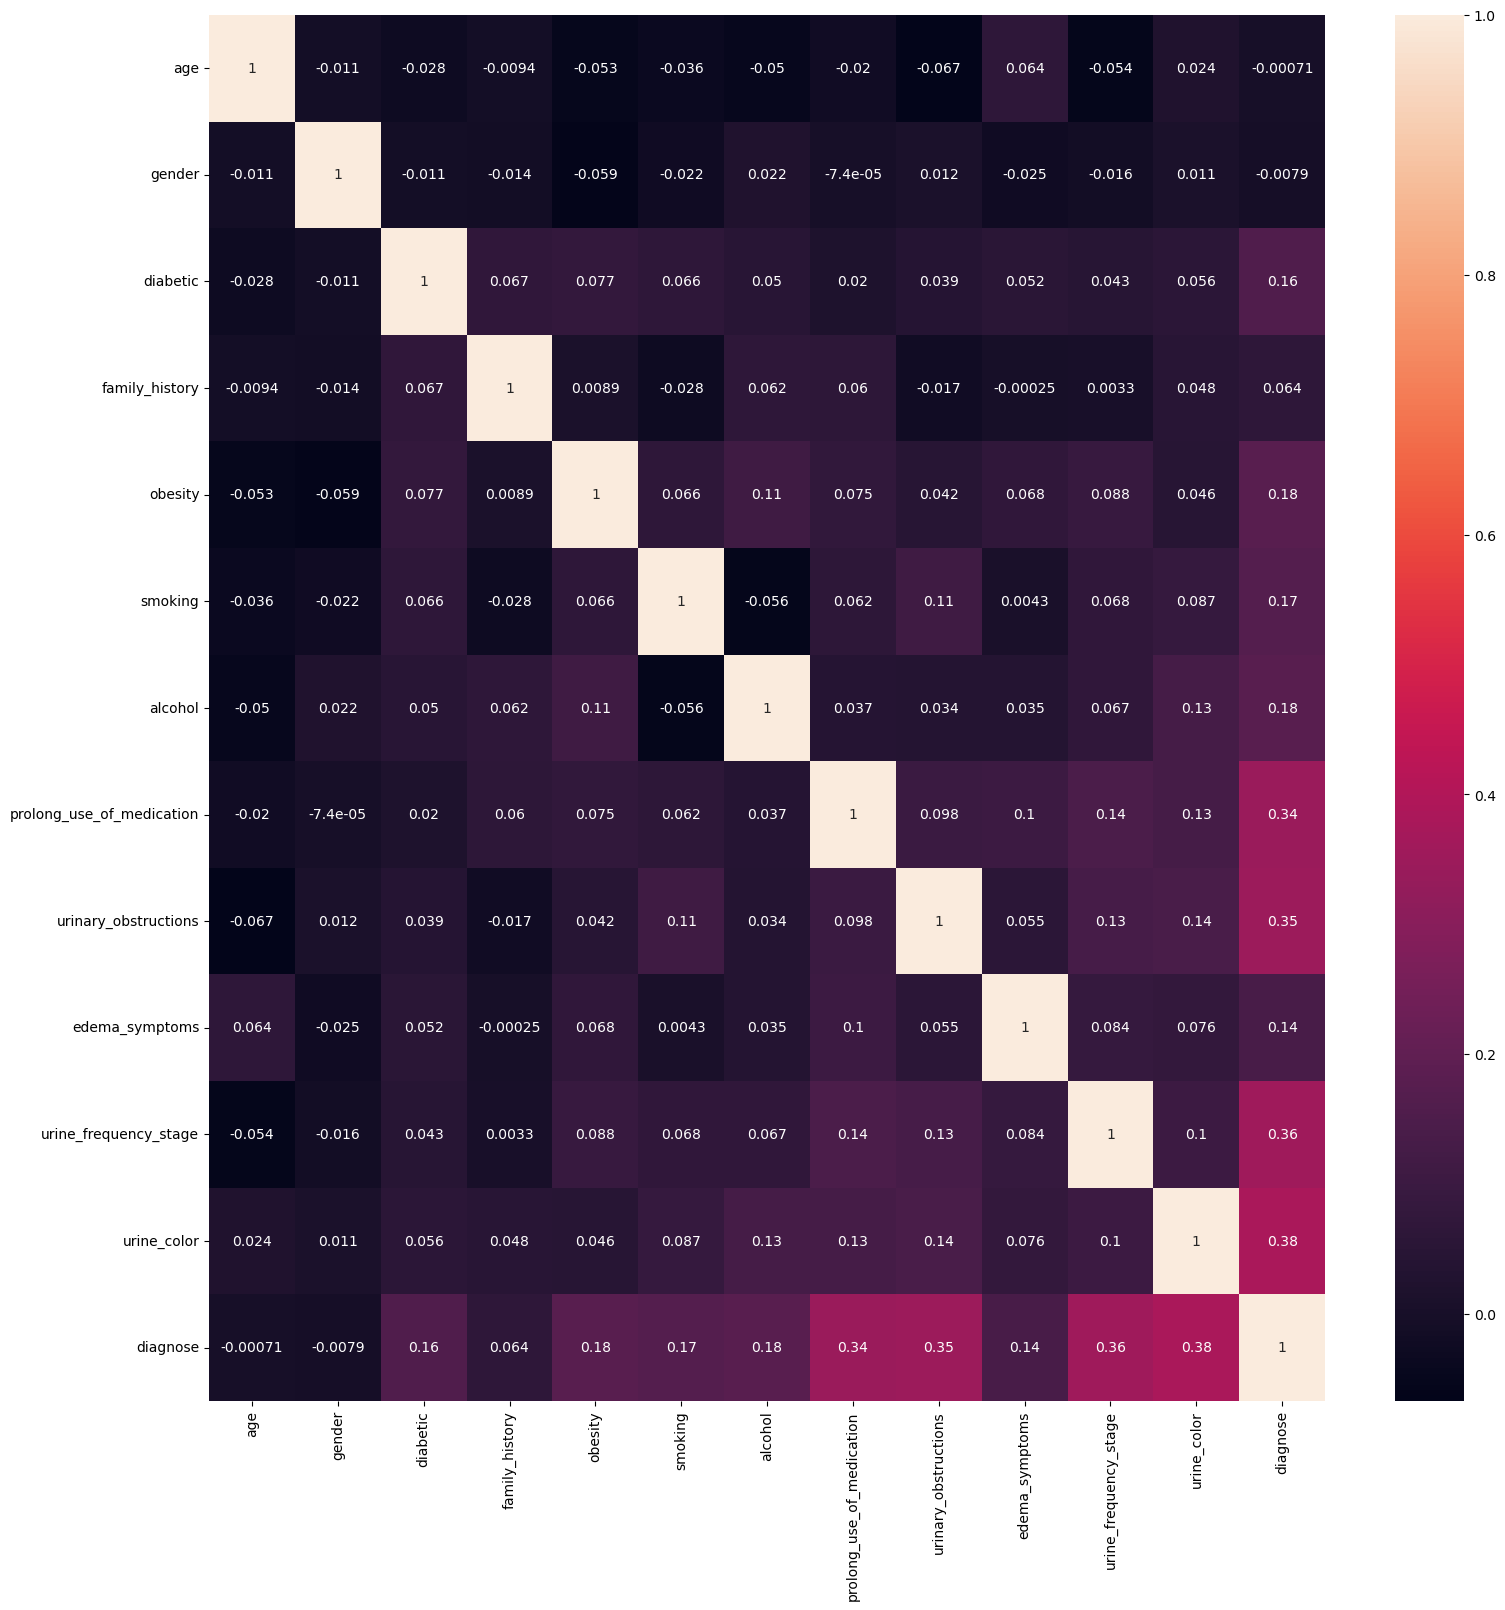

In [8]:
# 3. Data Visualization
corr = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=True)


In [9]:
# 4. Create feature matrix X and target vector y
X = df.drop('diagnose', axis=1)
y = df['diagnose']

In [10]:
# 5. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

def results(pred):
    print(classification_report(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 493 to 175
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   age                        484 non-null    int64
 1   gender                     484 non-null    int32
 2   diabetic                   484 non-null    int32
 3   family_history             484 non-null    int32
 4   obesity                    484 non-null    int32
 5   smoking                    484 non-null    int32
 6   alcohol                    484 non-null    int32
 7   prolong_use_of_medication  484 non-null    int32
 8   urinary_obstructions       484 non-null    int32
 9   edema_symptoms             484 non-null    int32
 10  urine_frequency_stage      484 non-null    int64
 11  urine_color                484 non-null    int64
dtypes: int32(9), int64(3)
memory usage: 32.1 KB


### 3. Model Training & Model Testing


#### Random Forest Classifier

In [12]:
# 6. Hyperparameter Tuning
rf = RandomForestClassifier()
weights = np.linspace(0.0, 0.99, 100)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'class_weight': [{0:x, 1:1.0-x} for x in weights]
}

gridSearch = GridSearchCV(estimator=rf,
                          param_grid=param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2).fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


              precision    recall  f1-score   support

           0       0.82      0.72      0.77        32
           1       0.90      0.94      0.92        90

    accuracy                           0.89       122
   macro avg       0.86      0.83      0.85       122
weighted avg       0.88      0.89      0.88       122



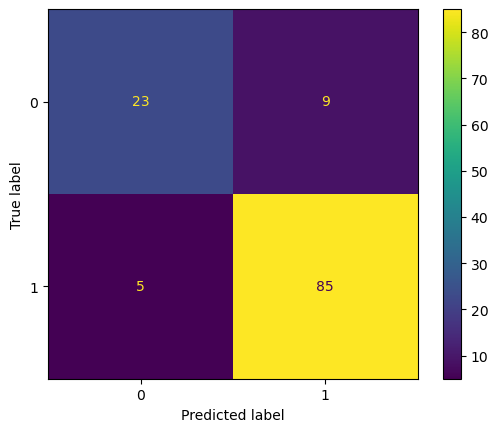

In [13]:
# 7. Model Training with Optimal Hyperparameters
rf = RandomForestClassifier(n_estimators=gridSearch.best_params_['n_estimators'],
                           max_depth=gridSearch.best_params_['max_depth'],
                           min_samples_split=gridSearch.best_params_['min_samples_split'],
                           min_samples_leaf=gridSearch.best_params_['min_samples_leaf'],
                           class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 8. Model Evaluation with Optimal Hyperparameters
results(y_pred_rf)

#### Support Vector Machine (SVM)

In [14]:
# Support Vector Machine (SVM)
svm = SVC(class_weight='balanced')
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
}

gridSearch_svm = GridSearchCV(estimator=svm,
                               param_grid=param_grid_svm,
                               cv=StratifiedKFold(),
                               n_jobs=-1,
                               scoring='f1',
                               verbose=2).fit(X_train, y_train)

print('Best SVM Score: %s' % gridSearch_svm.best_score_)
print('Best SVM Hyperparameters: %s' % gridSearch_svm.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Score: 0.9015267493635395
Best SVM Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.69      0.75      0.72        32
           1       0.91      0.88      0.89        90

    accuracy                           0.84       122
   macro avg       0.80      0.81      0.80       122
weighted avg       0.85      0.84      0.85       122



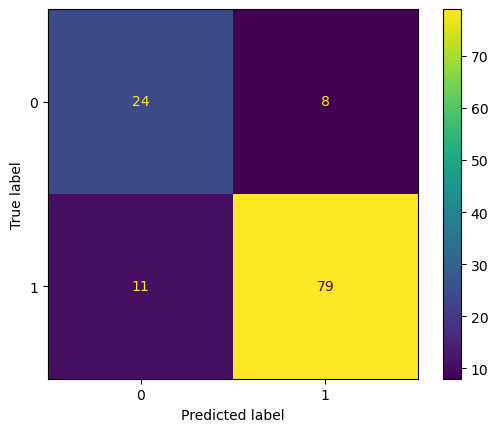

In [15]:
svm = SVC(kernel=gridSearch_svm.best_params_['kernel'],
          class_weight='balanced',
          C=gridSearch_svm.best_params_['C'],
          gamma=gridSearch_svm.best_params_['gamma'])

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
results(y_pred_svm)

#### Logistic Regression

In [16]:
# Logistic Regression
logistic_regression = LogisticRegression()  # Suitable for small datasets

weights = np.linspace(0.0, 0.99, 500)

param_grid_lr = {
    'C': [0.1, 1, 10],
    'class_weight': [{0:x, 1:1.0-x} for x in weights]
}

gridSearch_lr = GridSearchCV(estimator=logistic_regression,
                             param_grid=param_grid_lr,
                             cv=StratifiedKFold(),
                             n_jobs=-1,
                             scoring='f1',
                             verbose=2).fit(X_train, y_train)

print('Best Logistic Regression Score: %s' % gridSearch_lr.best_score_)
print('Best Logistic Regression Hyperparameters: %s' % gridSearch_lr.best_params_)


Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
Best Logistic Regression Score: 0.934787210669428
Best Logistic Regression Hyperparameters: {'C': 1, 'class_weight': {0: 0.4444088176352705, 1: 0.5555911823647295}}


              precision    recall  f1-score   support

           0       0.86      0.59      0.70        32
           1       0.87      0.97      0.92        90

    accuracy                           0.87       122
   macro avg       0.87      0.78      0.81       122
weighted avg       0.87      0.87      0.86       122



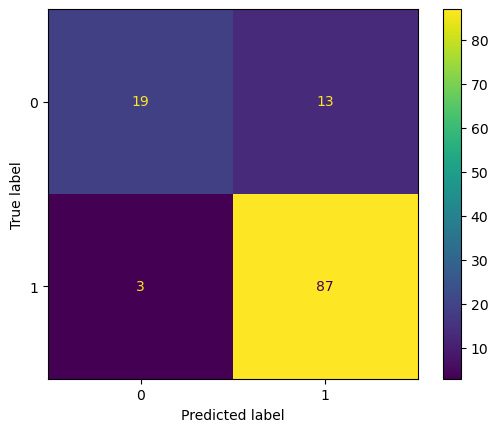

In [17]:
logistic_regression = LogisticRegression(class_weight=gridSearch_lr.best_params_['class_weight'], C=gridSearch_lr.best_params_['C'])
logistic_regression.fit(X_train, y_train)
y_pred_lr = logistic_regression.predict(X_test)
results(y_pred_lr)

##### Multinomial Naive Bayes

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

           0       0.65      0.41      0.50        32
           1       0.81      0.92      0.86        90

    accuracy                           0.79       122
   macro avg       0.73      0.66      0.68       122
weighted avg       0.77      0.79      0.77       122



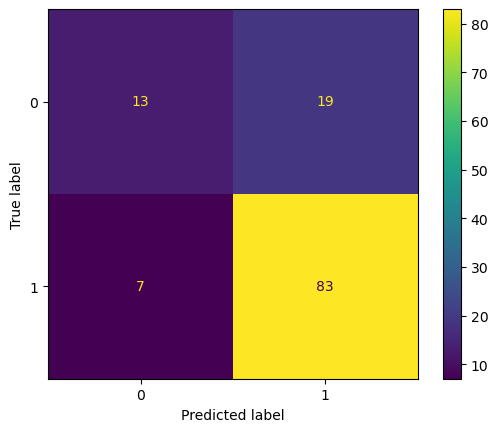

In [18]:
# Define the Naive Bayes model
class_weights = compute_class_weight('balanced', classes=y.unique(), y=y)
nb = MultinomialNB(class_prior=class_weights)

# Define the hyperparameters to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred_mnb = grid_search.predict(X_test)
results(y_pred_mnb)


### 4. Model Serialization

Best model for the given use case is Logistic Regression

System should be critical to False Negative (FN), (false positive results will be tested again in the next test stage.)  

In [19]:
with open("Logistic_Regression_model.pkl", "wb") as f:
    pickle.dump(logistic_regression, f)

In [20]:
Logistic_Regression_model = pickle.load(open('Logistic_Regression_model.pkl', 'rb'))

### 5. Prediction and Results

In [22]:
label_mapping = {0: "Not Risky", 1: "Risky"}

# Get user input for each feature.
feature1 = int(input("Age: "))
feature2 = int(input("Gender (M=1, F=0): "))
feature3 = int(input("Diabetic (Y=1, N=0): "))
feature4 = int(input("Family History (Y=1, N=0): "))
feature5 = int(input("Obesity (Y=1, N=0): "))
feature6 = int(input("Smoking (Y=1, N=0): "))
feature7 = int(input("Alcohol (Y=1, N=0): "))
feature8 = int(input("Prolong Use of Medication (Y=1, N=0): "))
feature9 = int(input("Urinary Obstructions (Y=1, N=0): "))
feature10 = int(input("Edema Symptoms (Y=1, N=0): "))
feature11 = int(input("Urinary Frequency (stages 1,2,3): "))
feature12 = int(input("Urine Colour (stages 1,2,3): "))

new_data = np.array([feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10, feature11, feature12])
new_data = new_data.reshape(1, -1)

# test_case_1 = np.array([59, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 3])

pk_pred = Logistic_Regression_model.predict(new_data)
predicted_label = label_mapping[pk_pred[0]]
print(f"Prediction for the test case:", predicted_label)


Age: 59
Gender (M=1, F=0): 0
Diabetic (Y=1, N=0): 1
Family History (Y=1, N=0): 1
Obesity (Y=1, N=0): 1
Smoking (Y=1, N=0): 0
Alcohol (Y=1, N=0): 1
Prolong Use of Medication (Y=1, N=0): 1
Urinary Obstructions (Y=1, N=0): 1
Edema Symptoms (Y=1, N=0): 1
Urinary Frequency (stages 1,2,3): 2
Urine Colour (stages 1,2,3): 3
Prediction for the test case: Risky
